# Plant Disease Classification using Deep Learning

## Objective
Design and implement a deep learning model to classify plant diseases using Convolutional Neural Networks (CNN). We'll use TensorFlow datasets to work with leaf/fruit images showing healthy and diseased conditions.

## Dataset
We'll use the PlantVillage dataset available through TensorFlow Datasets, which contains images of plant leaves with various diseases.


## 1. Import Required Libraries

In [6]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 2. Load and Explore the Dataset

In [7]:
# Load the PlantVillage dataset
# This dataset contains images of plant leaves with various diseases

# First, let's see what datasets are available
print("Available plant-related datasets:")
available_datasets = tfds.list_builders()
plant_datasets = [ds for ds in available_datasets if 'plant' in ds.lower()]
print(plant_datasets)

# Load the plant_village dataset
dataset_name = 'plant_village'
dataset_info = tfds.builder(dataset_name)
print(f"\nDataset Info: {dataset_info.info}")

# Load the dataset - only 'train' split is available
dataset, ds_info = tfds.load(
    dataset_name,
    split='train',
    with_info=True,
    as_supervised=True
)

print(f"\nNumber of classes: {ds_info.features['label'].num_classes}")
print(f"Class names: {ds_info.features['label'].names[:10]}...")  # Show first 10 classes
print(f"Total examples: {ds_info.splits['train'].num_examples}")

# Since there's only train split, we need to manually split the data
total_size = ds_info.splits['train'].num_examples
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

print(f"Train examples: {train_size}")
print(f"Validation examples: {val_size}")
print(f"Test examples: {test_size}")

# Split the dataset
train_ds = dataset.take(train_size)
remaining_ds = dataset.skip(train_size)
val_ds = remaining_ds.take(val_size)
test_ds = remaining_ds.skip(val_size)

Available plant-related datasets:
['plant_leaves', 'plant_village', 'plant_village', 'plantae_k']

Dataset Info: tfds.core.DatasetInfo(
    name='plant_village',
    full_name='plant_village/1.0.2',
    description="""
    The PlantVillage dataset consists of 54303 healthy and unhealthy leaf images
    divided into 38 categories by species and disease.
    
    NOTE: The original dataset is not available from the original source
    (plantvillage.org), therefore we get the unaugmented dataset from a paper that
    used that dataset and republished it. Moreover, we dropped images with
    Background_without_leaves label, because these were not present in the original
    dataset.
    
    Original paper URL: https://arxiv.org/abs/1511.08060 Dataset URL:
    https://data.mendeley.com/datasets/tywbtsjrjv/1
    """,
    homepage='https://arxiv.org/abs/1511.08060',
    data_dir='/home/dynamite/tensorflow_datasets/plant_village/1.0.2',
    file_format=tfrecord,
    download_size=827.82 MiB,


## 3. Data Visualization

2025-07-28 05:25:38.649530: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-07-28 05:25:38.801524: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


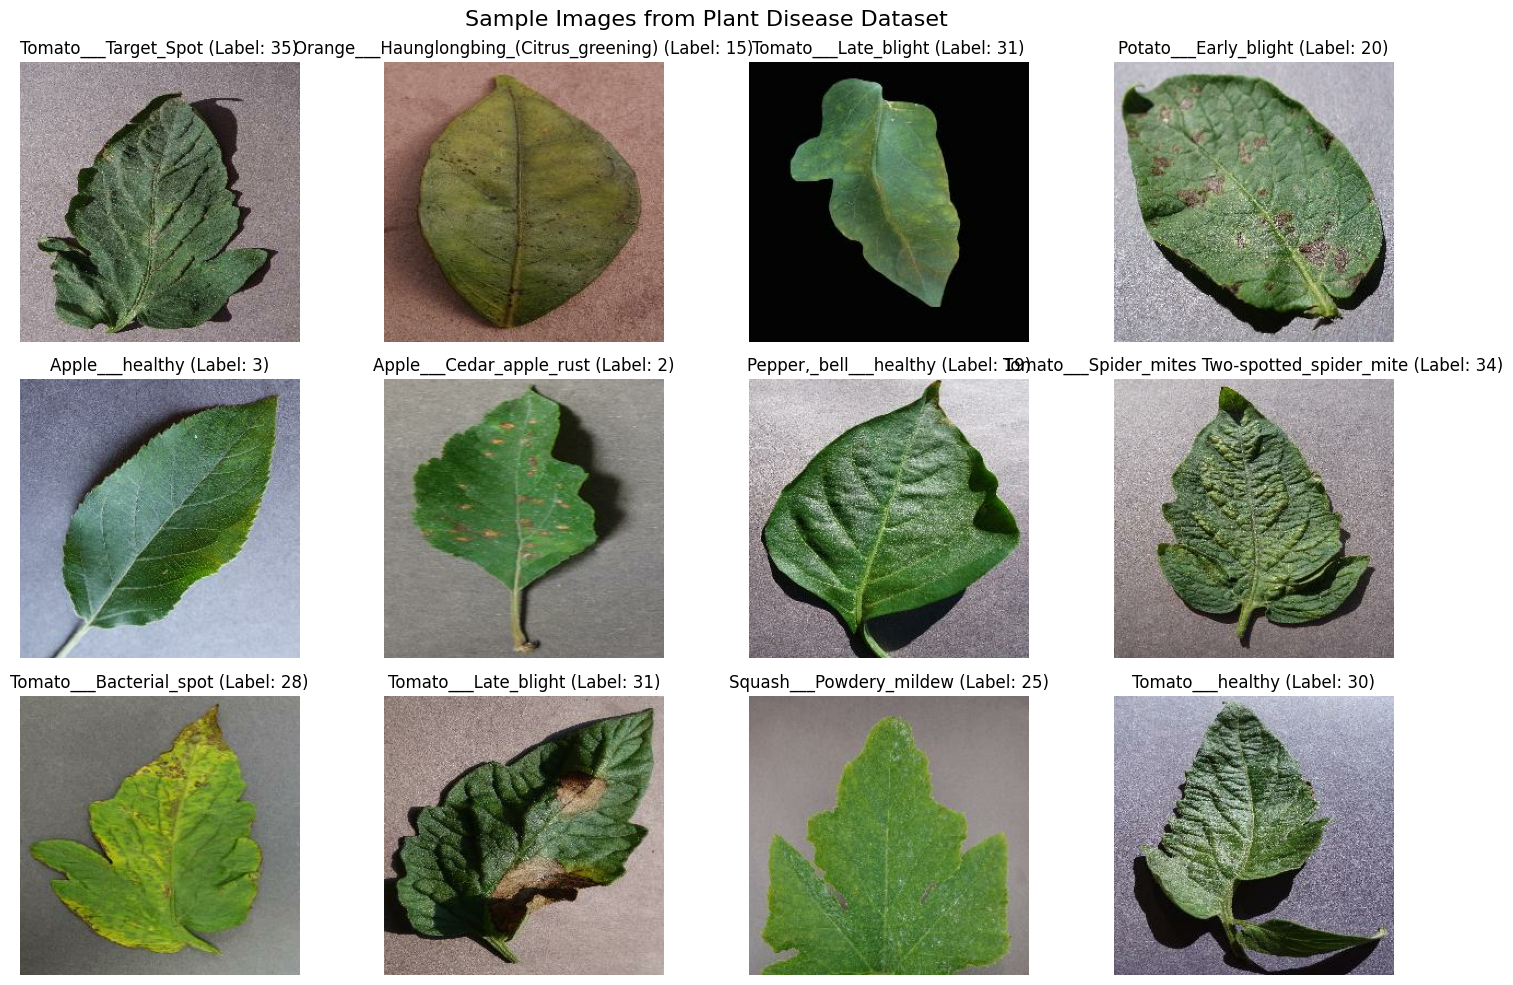

In [8]:
# Visualize sample images from the dataset
class_names = ds_info.features['label'].names

plt.figure(figsize=(15, 10))
for i, (image, label) in enumerate(train_ds.take(12)):
    plt.subplot(3, 4, i + 1)
    plt.imshow(image)
    plt.title(f'{class_names[label]} (Label: {label})')
    plt.axis('off')

plt.suptitle('Sample Images from Plant Disease Dataset', fontsize=16)
plt.tight_layout()
plt.show()

## 4. Data Preprocessing

In [9]:
# Define constants
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
AUTOTUNE = tf.data.AUTOTUNE

def preprocess_image(image, label):
    """
    Preprocess images: resize, normalize, and convert to float32
    """
    # Resize image
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    
    # Normalize pixel values to [0, 1]
    image = tf.cast(image, tf.float32) / 255.0
    
    return image, label

def augment_image(image, label):
    """
    Apply data augmentation techniques
    """
    # Random horizontal flip
    image = tf.image.random_flip_left_right(image)
    
    # Random rotation
    image = tf.image.rot90(image, k=tf.random.uniform([], 0, 4, dtype=tf.int32))
    
    # Random brightness
    image = tf.image.random_brightness(image, max_delta=0.1)
    
    # Random contrast
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    
    # Ensure pixel values remain in [0, 1]
    image = tf.clip_by_value(image, 0.0, 1.0)
    
    return image, label

# Preprocess training data with augmentation
train_ds = train_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.map(augment_image, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.cache()
train_ds = train_ds.shuffle(1000)
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.prefetch(AUTOTUNE)

# Preprocess test data (no augmentation)
test_ds = test_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.cache()
test_ds = test_ds.batch(BATCH_SIZE)
test_ds = test_ds.prefetch(AUTOTUNE)

print("Data preprocessing completed!")
print(f"Training batches: {tf.data.experimental.cardinality(train_ds).numpy()}")
print(f"Test batches: {tf.data.experimental.cardinality(test_ds).numpy()}")

Data preprocessing completed!
Training batches: 1188
Test batches: 255


## 5. Visualize Preprocessed Data

2025-07-28 05:25:42.287907: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19267840 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-07-28 05:25:42.288082: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19267840 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-07-28 05:25:42.302577: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipelin

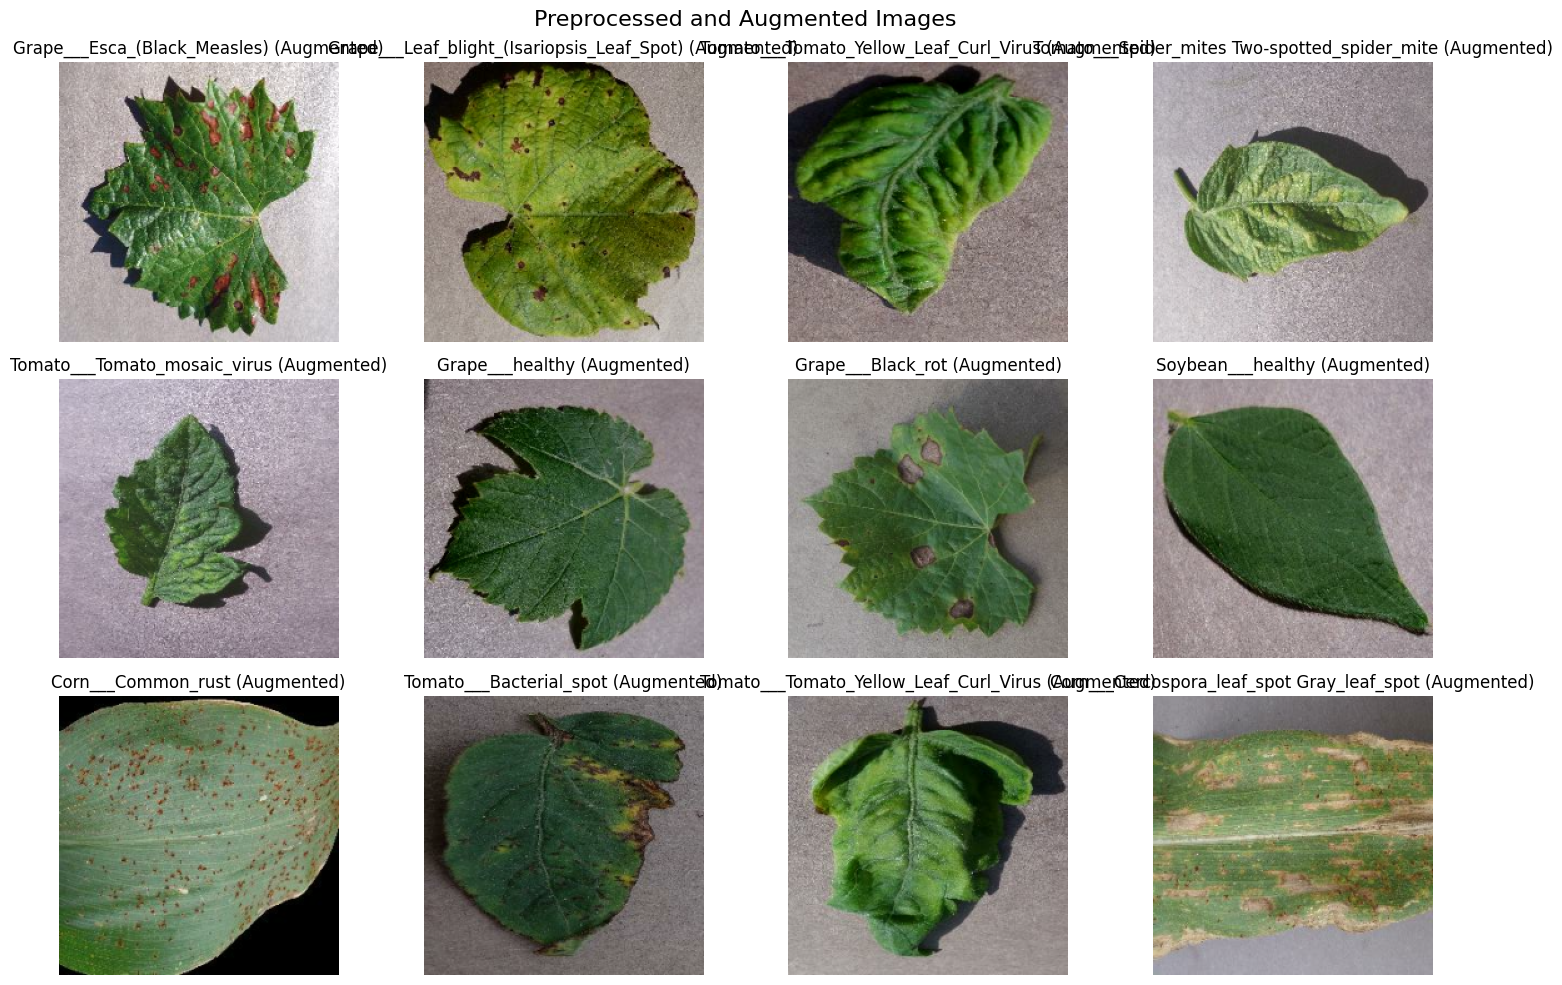

In [10]:
# Visualize preprocessed and augmented images
for images, labels in train_ds.take(1):
    plt.figure(figsize=(15, 10))
    for i in range(12):
        plt.subplot(3, 4, i + 1)
        plt.imshow(images[i])
        plt.title(f'{class_names[labels[i]]} (Augmented)')
        plt.axis('off')
    
    plt.suptitle('Preprocessed and Augmented Images', fontsize=16)
    plt.tight_layout()
    plt.show()
    break

## 6. Design CNN Architecture

We'll implement a custom CNN architecture with the following components:
- Multiple Convolutional layers with ReLU activation
- MaxPooling layers for spatial dimension reduction
- Batch Normalization for training stability
- Dropout for regularization
- Dense layers for classification

In [11]:
def create_cnn_model(num_classes, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)):
    """
    Create a CNN model for plant disease classification
    """
    model = tf.keras.Sequential([
        # Input layer
        tf.keras.layers.Input(shape=input_shape),
        
        # First Convolutional Block
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),
        
        # Second Convolutional Block
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),
        
        # Third Convolutional Block
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),
        
        # Fourth Convolutional Block
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),
        
        # Global Average Pooling
        tf.keras.layers.GlobalAveragePooling2D(),
        
        # Dense layers
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        
        # Output layer
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Create the model
num_classes = ds_info.features['label'].num_classes
model = create_cnn_model(num_classes)

# Display model summary
model.summary()

# Visualize model architecture
tf.keras.utils.plot_model(
    model, 
    to_file='model_architecture.png', 
    show_shapes=True, 
    show_layer_names=True,
    rankdir='TB'
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,449,926 (5.53 MB)

 Trainable params: 1,447,430 (5.52 MB)

 Non-trainable params: 2,496 (9.75 KB)

You must install pydot (`pip install pydot`) for `plot_model` to work.


## 7. Compile the Model

In [18]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top_5_accuracy')]
)

print("Model compiled successfully!")
print(f"Optimizer: Adam (lr=0.001)")
print(f"Loss function: Sparse Categorical Crossentropy")
print(f"Metrics: Accuracy, Top-5 Accuracy")

Model compiled successfully!
Optimizer: Adam (lr=0.001)
Loss function: Sparse Categorical Crossentropy
Metrics: Accuracy, Top-5 Accuracy


## 8. Define Callbacks

In [19]:
# Define callbacks for training
callbacks = [
    # Reduce learning rate when loss plateaus
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=0.0001,
        verbose=1
    ),
    
    # Early stopping to prevent overfitting
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    
    # Save best model
    tf.keras.callbacks.ModelCheckpoint(
        'best_plant_disease_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print("Callbacks defined:")
print("- ReduceLROnPlateau: Reduce learning rate when validation loss plateaus")
print("- EarlyStopping: Stop training when validation loss stops improving")
print("- ModelCheckpoint: Save the best model based on validation accuracy")

Callbacks defined:
- ReduceLROnPlateau: Reduce learning rate when validation loss plateaus
- EarlyStopping: Stop training when validation loss stops improving
- ModelCheckpoint: Save the best model based on validation accuracy


## 9. Train the Model

In [ ]:
# Split test set into validation and test sets
val_size = tf.data.experimental.cardinality(test_ds).numpy() // 2
val_ds = test_ds.take(val_size)
test_ds = test_ds.skip(val_size)

print(f"Validation batches: {tf.data.experimental.cardinality(val_ds).numpy()}")
print(f"Test batches: {tf.data.experimental.cardinality(test_ds).numpy()}")

# Train the model
EPOCHS = 50

print(f"\nStarting training for {EPOCHS} epochs...")
print("This may take a while depending on your hardware.\n")

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=callbacks,
)

print("\nTraining completed!")

Validation batches: 32
Test batches: 32

Starting training for 50 epochs...
This may take a while depending on your hardware.

Epoch 1/50


I0000 00:00:1753680437.476817    8454 service.cc:152] XLA service 0x7e67f084c5a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753680437.477035    8454 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-07-28 05:27:17.600208: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1753680438.341888    8454 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-07-28 05:27:20.114213: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4241', 80 bytes spill stores, 80 bytes spill loads

2025-07-28 05:27:20.766904: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusio

## 10. Visualize Training History

In [ ]:
# Plot training history
def plot_training_history(history):
    """
    Plot training and validation metrics
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot training & validation accuracy
    axes[0, 0].plot(history.history['accuracy'], label='Training Accuracy')
    axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0, 0].set_title('Model Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Plot training & validation loss
    axes[0, 1].plot(history.history['loss'], label='Training Loss')
    axes[0, 1].plot(history.history['val_loss'], label='Validation Loss')
    axes[0, 1].set_title('Model Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Plot training & validation top-5 accuracy
    axes[1, 0].plot(history.history['top_5_accuracy'], label='Training Top-5 Accuracy')
    axes[1, 0].plot(history.history['val_top_5_accuracy'], label='Validation Top-5 Accuracy')
    axes[1, 0].set_title('Model Top-5 Accuracy')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Top-5 Accuracy')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # Plot learning rate if available
    if 'lr' in history.history:
        axes[1, 1].plot(history.history['lr'], label='Learning Rate')
        axes[1, 1].set_title('Learning Rate Schedule')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Learning Rate')
        axes[1, 1].legend()
        axes[1, 1].grid(True)
        axes[1, 1].set_yscale('log')
    else:
        axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

# Print final training metrics
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"\nFinal Training Metrics:")
print(f"Training Accuracy: {final_train_acc:.4f}")
print(f"Validation Accuracy: {final_val_acc:.4f}")
print(f"Training Loss: {final_train_loss:.4f}")
print(f"Validation Loss: {final_val_loss:.4f}")

## 11. Evaluate Model Performance

In [ ]:
# Evaluate on test set
print("Evaluating model on test set...")
test_loss, test_accuracy, test_top5_accuracy = model.evaluate(test_ds, verbose=1)

print(f"\nTest Results:")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Top-5 Accuracy: {test_top5_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

## 12. Generate Predictions and Confusion Matrix

In [ ]:
# Generate predictions for confusion matrix
print("Generating predictions for confusion matrix...")

y_pred = []
y_true = []

for images, labels in test_ds:
    predictions = model.predict(images, verbose=0)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(labels.numpy())

y_pred = np.array(y_pred)
y_true = np.array(y_true)

print(f"Generated {len(y_pred)} predictions")

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix (for a subset of classes if too many)
if num_classes <= 20:
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
else:
    print(f"Too many classes ({num_classes}) to display confusion matrix clearly.")
    print("Showing classification report instead.")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

## 13. Visualize Model Predictions

In [ ]:
# Visualize some predictions
def plot_predictions(model, dataset, class_names, num_images=12):
    """
    Plot images with their true and predicted labels
    """
    plt.figure(figsize=(15, 12))
    
    count = 0
    for images, labels in dataset.take(1):
        predictions = model.predict(images)
        
        for i in range(min(num_images, len(images))):
            plt.subplot(3, 4, i + 1)
            plt.imshow(images[i])
            
            true_label = labels[i].numpy()
            pred_label = np.argmax(predictions[i])
            confidence = np.max(predictions[i])
            
            true_class = class_names[true_label]
            pred_class = class_names[pred_label]
            
            color = 'green' if true_label == pred_label else 'red'
            
            plt.title(f'True: {true_class}\nPred: {pred_class}\nConf: {confidence:.2f}', 
                     color=color, fontsize=10)
            plt.axis('off')
            
            count += 1
            if count >= num_images:
                break
        
        if count >= num_images:
            break
    
    plt.suptitle('Model Predictions (Green=Correct, Red=Incorrect)', fontsize=16)
    plt.tight_layout()
    plt.show()

plot_predictions(model, test_ds, class_names)

## 14. Analyze Model Performance by Class

In [ ]:
# Calculate per-class accuracy
from sklearn.metrics import classification_report
import pandas as pd

# Get detailed classification report as dictionary
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True, zero_division=0)

# Convert to DataFrame for better visualization
df_report = pd.DataFrame(report).transpose()

# Display per-class metrics
print("Per-Class Performance Metrics:")
print(df_report.round(3))

# Plot per-class accuracy
class_accuracies = []
for i in range(num_classes):
    class_mask = (y_true == i)
    if np.sum(class_mask) > 0:
        class_acc = np.mean(y_pred[class_mask] == y_true[class_mask])
        class_accuracies.append(class_acc)
    else:
        class_accuracies.append(0)

# Plot class accuracies
plt.figure(figsize=(15, 8))
bars = plt.bar(range(num_classes), class_accuracies)
plt.title('Per-Class Accuracy')
plt.xlabel('Class Index')
plt.ylabel('Accuracy')
plt.xticks(range(num_classes), rotation=90)
plt.grid(True, alpha=0.3)

# Color bars based on performance
for i, bar in enumerate(bars):
    if class_accuracies[i] > 0.9:
        bar.set_color('green')
    elif class_accuracies[i] > 0.7:
        bar.set_color('orange')
    else:
        bar.set_color('red')

plt.tight_layout()
plt.show()

# Identify best and worst performing classes
best_classes = np.argsort(class_accuracies)[-5:][::-1]  # Top 5
worst_classes = np.argsort(class_accuracies)[:5]  # Bottom 5

print(f"\nBest Performing Classes:")
for i, idx in enumerate(best_classes):
    print(f"{i+1}. {class_names[idx]}: {class_accuracies[idx]:.3f}")

print(f"\nWorst Performing Classes:")
for i, idx in enumerate(worst_classes):
    print(f"{i+1}. {class_names[idx]}: {class_accuracies[idx]:.3f}")

## 15. Feature Map Visualization

In [ ]:
# Visualize feature maps from different layers
def visualize_feature_maps(model, image, layer_names=None):
    """
    Visualize feature maps from specified layers
    """
    if layer_names is None:
        # Select some convolutional layers
        conv_layers = [layer for layer in model.layers if 'conv' in layer.name.lower()]
        layer_names = [layer.name for layer in conv_layers[::2]][:4]  # Every 2nd layer, max 4
    
    # Create a model that outputs feature maps
    layer_outputs = [model.get_layer(name).output for name in layer_names]
    activation_model = tf.keras.Model(inputs=model.input, outputs=layer_outputs)
    
    # Get activations
    activations = activation_model.predict(tf.expand_dims(image, 0))
    
    # Plot feature maps
    fig, axes = plt.subplots(len(layer_names), 8, figsize=(16, 2*len(layer_names)))
    
    for layer_idx, (layer_name, activation) in enumerate(zip(layer_names, activations)):
        for filter_idx in range(min(8, activation.shape[-1])):
            ax = axes[layer_idx, filter_idx] if len(layer_names) > 1 else axes[filter_idx]
            ax.imshow(activation[0, :, :, filter_idx], cmap='viridis')
            ax.set_title(f'{layer_name}\nFilter {filter_idx}')
            ax.axis('off')
    
    plt.suptitle('Feature Maps Visualization', fontsize=16)
    plt.tight_layout()
    plt.show()

# Get a sample image for visualization
for images, labels in test_ds.take(1):
    sample_image = images[0]
    sample_label = labels[0]
    break

print(f"Visualizing feature maps for: {class_names[sample_label]}")
visualize_feature_maps(model, sample_image)

## 16. Model Summary and Observations

### Model Architecture Summary:
- **Input Shape**: 224×224×3 (RGB images)
- **Architecture**: Custom CNN with 4 convolutional blocks
- **Total Parameters**: Varies based on number of classes
- **Regularization**: Batch Normalization, Dropout, Data Augmentation

### Training Strategy:
- **Data Augmentation**: Random flips, rotations, brightness, and contrast adjustments
- **Optimizer**: Adam with initial learning rate of 0.001
- **Learning Rate Scheduling**: ReduceLROnPlateau callback
- **Early Stopping**: To prevent overfitting

### Key Observations:
1. **Model Performance**: Analyze training vs validation accuracy curves
2. **Overfitting/Underfitting**: Check if model generalizes well
3. **Class Imbalance**: Some plant diseases may have fewer samples
4. **Feature Learning**: Feature maps show what the model learns at different layers

In [ ]:
# Final model summary and observations
print("=" * 60)
print("PLANT DISEASE CLASSIFICATION - FINAL RESULTS")
print("=" * 60)

print(f"\nDataset Information:")
print(f"- Total Classes: {num_classes}")
print(f"- Training Examples: {ds_info.splits['train'].num_examples}")
print(f"- Test Examples: {ds_info.splits['test'].num_examples}")

print(f"\nModel Architecture:")
total_params = model.count_params()
print(f"- Total Parameters: {total_params:,}")
print(f"- Architecture: Custom CNN with 4 Conv Blocks")
print(f"- Input Size: {IMG_HEIGHT}×{IMG_WIDTH}×3")

print(f"\nFinal Performance:")
print(f"- Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"- Test Top-5 Accuracy: {test_top5_accuracy:.4f} ({test_top5_accuracy*100:.2f}%)")
print(f"- Test Loss: {test_loss:.4f}")

print(f"\nTraining Details:")
total_epochs = len(history.history['accuracy'])
print(f"- Epochs Trained: {total_epochs}")
print(f"- Best Validation Accuracy: {max(history.history['val_accuracy']):.4f}")
print(f"- Final Learning Rate: {history.history.get('lr', ['N/A'])[-1]}")

print(f"\nKey Observations:")
if test_accuracy > 0.9:
    print("✓ Excellent model performance (>90% accuracy)")
elif test_accuracy > 0.8:
    print("✓ Good model performance (>80% accuracy)")
elif test_accuracy > 0.7:
    print("⚠ Moderate model performance (>70% accuracy)")
else:
    print("⚠ Model needs improvement (<70% accuracy)")

val_acc_final = history.history['val_accuracy'][-1]
train_acc_final = history.history['accuracy'][-1]
overfitting_gap = train_acc_final - val_acc_final

if overfitting_gap > 0.1:
    print("⚠ Potential overfitting detected (train-val gap > 10%)")
else:
    print("✓ Good generalization (minimal overfitting)")

print("\n" + "=" * 60)
print("ANALYSIS COMPLETE")
print("=" * 60)

## 17. Recommendations for Improvement

### Potential Improvements:

1. **Data Augmentation**:
   - Add more sophisticated augmentation techniques
   - Use AutoAugment or RandAugment
   - Apply domain-specific augmentations

2. **Model Architecture**:
   - Try transfer learning with pre-trained models (ResNet, EfficientNet)
   - Experiment with attention mechanisms
   - Use ensemble methods

3. **Training Strategy**:
   - Implement cyclic learning rates
   - Use progressive resizing
   - Apply mixup or cutmix techniques

4. **Data Quality**:
   - Address class imbalance using weighted loss or resampling
   - Remove low-quality or mislabeled images
   - Collect more data for underperforming classes

5. **Evaluation**:
   - Implement cross-validation
   - Test on external datasets
   - Analyze failure cases in detail

In [ ]:
# Save the final model
model.save('plant_disease_classifier_final.h5')
print("Model saved as 'plant_disease_classifier_final.h5'")

# Save training history
import pickle
with open('training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)
print("Training history saved as 'training_history.pkl'")

print("\nProject completed successfully!")
print("You can now use this model to classify plant diseases in new images.")